# PLS Regression

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [4]:
from common.data import get_data
from common.paths import HEALTHY, WISC

X, Y, demographics, population = get_data(label_path=WISC)
ages = demographics['Age']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (380, 34716) | Y: 6 | Age: (380,) | Population: adhd


In [5]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'y: {y.shape}')

y: (106,)


In [6]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 1: (114, 34716) | Bin 2: (152, 34716) | Bin 3: (114, 34716)


## Run for one target, one age bin

In [3]:
from common.scoring import unimetric_scorer, multimetric_scorer, N_PERM, SCORING, RKF_10_10
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_validate, permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### Set up the model pipeline, metrics, and cross-validation approach

In [5]:
estimators = [StandardScaler(), PLSRegression(n_components=4)]
pipe = make_pipeline(*estimators)

### Run cross-validation

In [6]:
%%time

# X_cv = bin_3[0]
# y_cv = bin_3[1]
X_cv = X
y_cv = y
age_group = 'all'

scores = cross_validate(pipe, X_cv, y_cv, cv=RKF_10_10, scoring=unimetric_scorer, n_jobs=-1, 
                        return_train_score=True, return_estimator=True)

coefs = np.array([estimator['plsregression'].coef_ for estimator in scores['estimator']])
coefs = np.squeeze(coefs, axis=2)
avg_coef = np.mean(coefs, axis=0)

print(f'pls_{population}_{selected_target}_{age_group}')
for metric in SCORING:
    metric_values = scores[metric]
    print(f'Avg {metric}: {np.mean(metric_values):.2f}')

0.18997362711567398
CPU times: user 1.94 s, sys: 1.07 s, total: 3.01 s
Wall time: 6.84 s


In [5]:
%%time
from sklearn.metrics import r2_score

def cust_r2(model, X, y):
    return r2_score(y, model.predict(X))

scores = []

for _ in range(100):
    subsample_idx = np.random.choice(len(X), 106)
    X_sub, ages_sub = X[subsample_idx], ages[subsample_idx]
    
    estimators = [StandardScaler(), PLSRegression(n_components=4)]
    pipe = make_pipeline(*estimators)
    score = cross_validate(pipe, X_sub, ages_sub, cv=RKF_10_10, scoring=cust_r2, n_jobs=-1, 
                           return_train_score=False, return_estimator=False)
    scores.append(np.mean(score['test_score']))

CPU times: user 1min 52s, sys: 7.44 s, total: 1min 59s
Wall time: 17min 28s


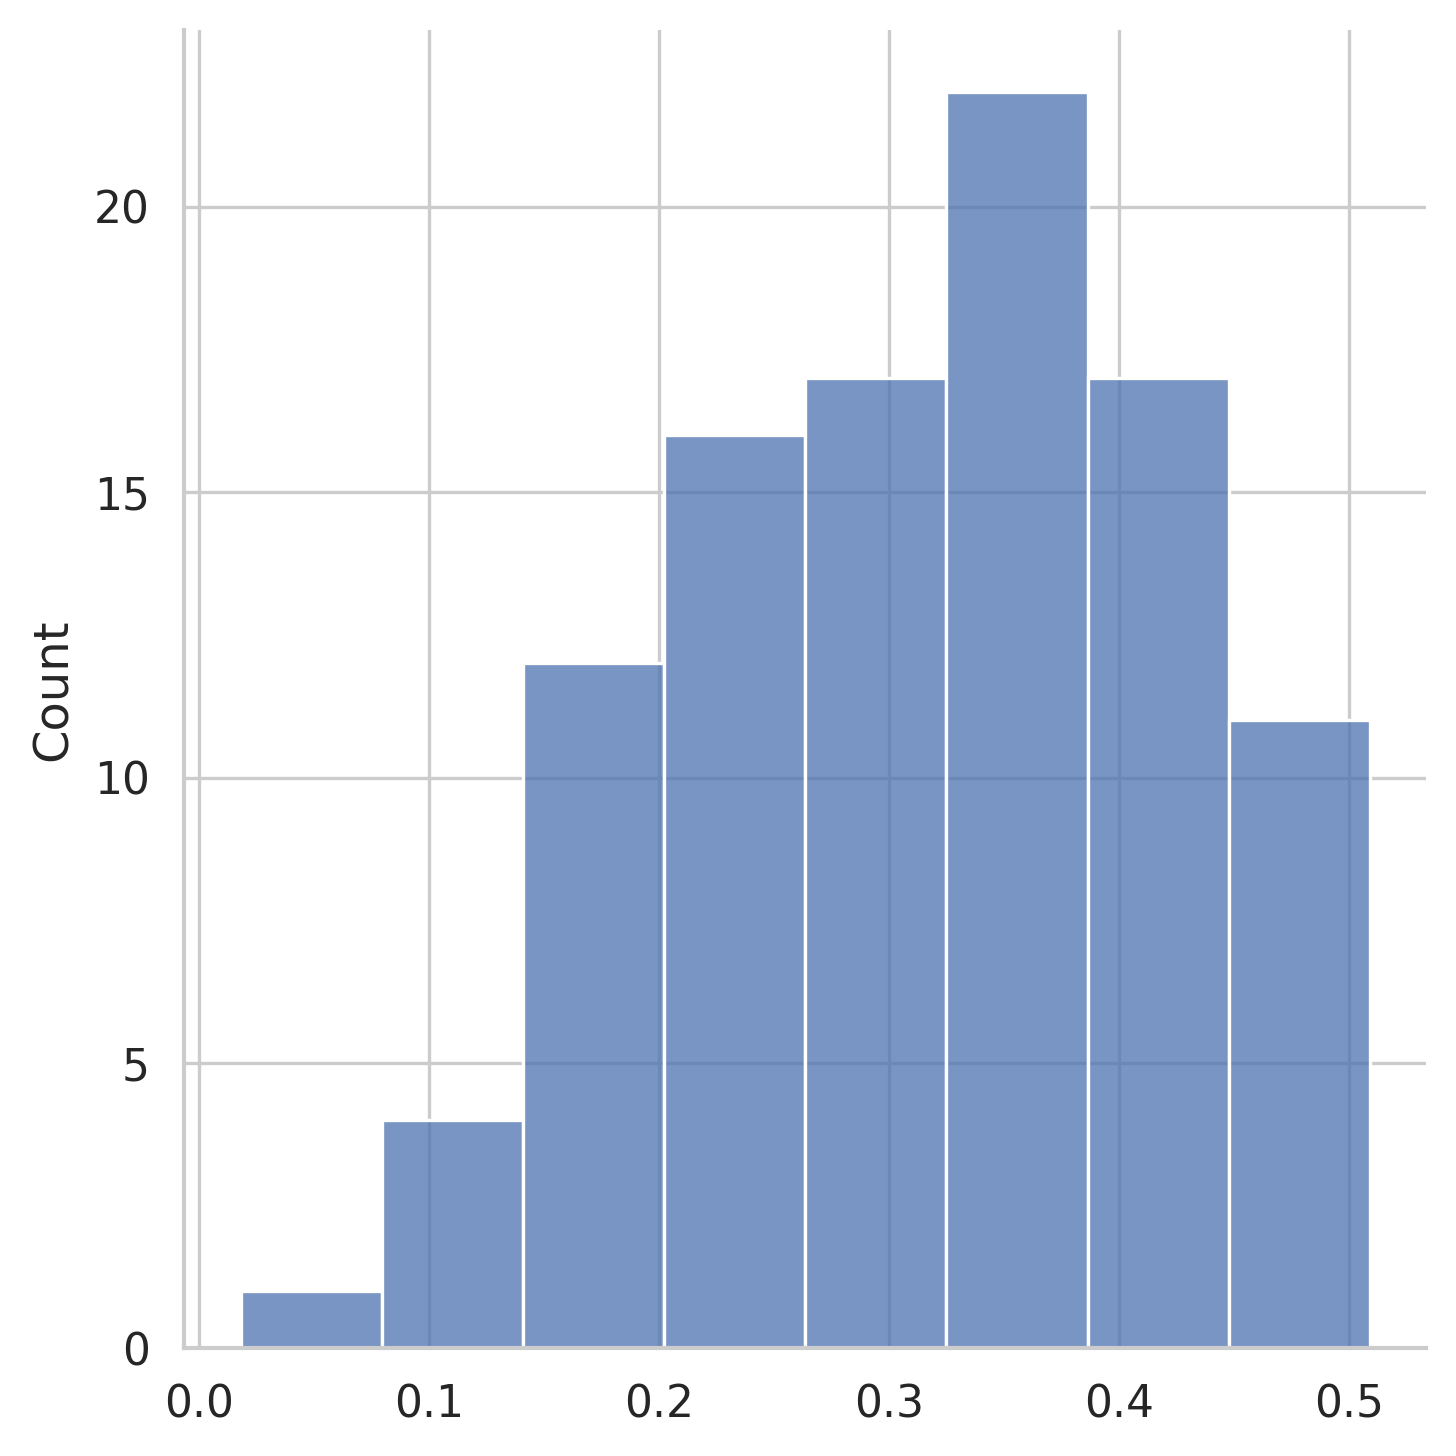

In [6]:
sns.displot(scores)

In [ ]:
ax = sns.boxplot(data=scores['test_p_value'], palette="Set2")
ax = sns.swarmplot(data=scores['test_p_value'], color="0.3")
ax.set_ylabel('Test Score (Pearson r)')
ax.set_xlabel('Groups')
ax.set_title('Cross Validation Results ( -> )')

In [30]:
from os.path import join
from common.paths import PLS_WEIGHTS

filename = f'pls_{population}_{selected_target}_{age_group}.npy'

np.save(join(PLS_WEIGHTS, filename), avg_coef)

### ICC

In [31]:
%%time
import pingouin as pg

icc_data = pd.DataFrame(coefs).melt(var_name='connection', value_name='weight', ignore_index=False)
icc_data['cv_run_num'] = icc_data.index
icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='cv_run_num', ratings='weight').round(3)
icc.set_index("Type")

CPU times: user 17min 38s, sys: 7.77 s, total: 17min 46s
Wall time: 17min 45s


,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.892,823.213,34715,3436884,0.0,"[0.89, 0.89]"
ICC2,Single random raters,0.892,823.298,34715,3436785,0.0,"[0.89, 0.89]"
ICC3,Single fixed raters,0.892,823.298,34715,3436785,0.0,"[0.89, 0.89]"
ICC1k,Average raters absolute,0.999,823.213,34715,3436884,0.0,"[1.0, 1.0]"
ICC2k,Average random raters,0.999,823.298,34715,3436785,0.0,"[1.0, 1.0]"
ICC3k,Average fixed raters,0.999,823.298,34715,3436785,0.0,"[1.0, 1.0]"


### Run permutation statistic

In [23]:
%%time
# X_cv = bin_1[0]
# y_cv = bin_1[1]
X_cv = X
y_cv = y
age_group = 'all'

score, _, pvalue = permutation_test_score(
    pipe, X_cv, y_cv, cv=RKF_10_10, scoring=unimetric_scorer, n_permutations=N_PERM, n_jobs=-1)

print(f'pls_{population}_{selected_target}_{age_group}')
print(f'Score: {score:.2f} | p-value: {pvalue:.4f}')

pls_healthy_WISC_PSI_all
Score: -0.06 | p-value: 0.6934
CPU times: user 2min 9s, sys: 4.18 s, total: 2min 13s
Wall time: 4h 47min 31s


In [9]:
%%time
X_cv = X
y_cv = ages

score, perm_scores, pvalue = permutation_test_score(pipe, X_cv, y_cv, cv=RKF_10_10, 
                                          scoring=cust_r2, n_permutations=N_PERM, n_jobs=-1)

print(f'Score: {score:.2f} | p-value: {pvalue:.4f}')

Score: 0.17 | p-value: 0.0020
CPU times: user 1min 44s, sys: 2.31 s, total: 1min 47s
Wall time: 39min 18s


## Run for all targets, all age bins

### Run cross-validation

In [15]:
%%time
from os.path import join
from common.binning import bin_data
from common.wisc import FSIQ, PRIMARY_INDICES
from common.paths import PLS_WEIGHTS, PLS_RESULTS

results = []
targets = FSIQ + PRIMARY_INDICES

for target in targets:
    y = Y[target]
    X_all, y_all, bin_labels = bin_data(X, y)
    
    for X_cv, y_cv, bin_label in zip(X_all, y_all, bin_labels):
        scores = cross_validate(pipe, X_cv, y_cv, cv=RKF_10_10, 
                                scoring=unimetric_scorer, n_jobs=-1, 
                                return_train_score=False, 
                                return_estimator=True)
        coefs = np.array([estimator['plsregression'].coef_ for estimator in scores['estimator']])
        coefs = np.squeeze(coefs, axis=2)
        avg_coef = np.mean(coefs, axis=0)
        
        results.append({    
            'Model': 'pls',
            'Population': population,
            'Target': target,
            'Bin': bin_label,
            'Score': np.mean(scores['test_score']),
        })
        print(results[-1])
        
        filename = f'pls_{population}_{target}_{bin_label}.npy'
        np.save(join(PLS_WEIGHTS, filename), avg_coef)

results_df = pd.DataFrame(results)
display(results_df.round(4))
filename = f'pls_cv_{population}.csv'
results_df.to_csv(join(PLS_RESULTS, filename))

{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_FSIQ', 'Bin': 'All', 'Score': 0.05635758984112808}
{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_VSI', 'Bin': 'All', 'Score': 0.10961213762939304}
{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_VCI', 'Bin': 'All', 'Score': 0.2413842533635157}
{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_FRI', 'Bin': 'All', 'Score': -0.06690211713566536}
{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_WMI', 'Bin': 'All', 'Score': 0.09844717189572955}
{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_PSI', 'Bin': 'All', 'Score': -0.08364363560297766}


,Model,Population,Target,Bin,Score
0,pls,healthy,WISC_FSIQ,All,0.0564
1,pls,healthy,WISC_VSI,All,0.1096
2,pls,healthy,WISC_VCI,All,0.2414
3,pls,healthy,WISC_FRI,All,-0.0669
4,pls,healthy,WISC_WMI,All,0.0984
5,pls,healthy,WISC_PSI,All,-0.0836


CPU times: user 7.41 s, sys: 2.95 s, total: 10.4 s
Wall time: 29 s


### Run permutation test statistic (pts)

In [6]:
%%time
from os.path import join
from common.binning import bin_data
from common.wisc import FSIQ, PRIMARY_INDICES
from common.paths import PLS_RESULTS

results = []
targets = FSIQ + PRIMARY_INDICES

for target in targets:
    y = Y[target]
    X_all, y_all, bin_labels = bin_data(X, y, ages)
    
    for X_cv, y_cv, bin_label in zip(X_all, y_all, bin_labels):
        score, permutation_scores, pvalue = permutation_test_score(
            pipe, X_cv, y_cv, cv=RKF_10_10, scoring=unimetric_scorer, n_permutations=N_PERM, 
            n_jobs=-1)
        results.append({    
            'Model': 'pls',
            'Population': population,
            'Target': target,
            'Bin': bin_label,
            'Score': score,
            'P-value': pvalue,
        })
        print(results[-1])

results_df = pd.DataFrame(results)
display(results_df.round(4))
filename = f'pls_pts_{population}.csv'
results_df.to_csv(join(PLS_RESULTS, filename))

{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_FSIQ', 'Bin': 'All', 'Score': 0.041318758674924475, 'P-value': 0.3886113886113886}
{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_VSI', 'Bin': 'All', 'Score': 0.1445271320822533, 'P-value': 0.12987012987012986}
{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_VCI', 'Bin': 'All', 'Score': 0.22517123898730498, 'P-value': 0.03596403596403597}
{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_FRI', 'Bin': 'All', 'Score': -0.06825133305788804, 'P-value': 0.7372627372627373}
{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_WMI', 'Bin': 'All', 'Score': 0.07780232068260588, 'P-value': 0.2597402597402597}
{'Model': 'pls', 'Population': 'healthy', 'Target': 'WISC_PSI', 'Bin': 'All', 'Score': -0.09971236019558605, 'P-value': 0.7912087912087912}


,Model,Population,Target,Bin,Score,P-value
0,pls,healthy,WISC_FSIQ,All,0.0413,0.3886
1,pls,healthy,WISC_VSI,All,0.1445,0.1299
2,pls,healthy,WISC_VCI,All,0.2252,0.0360
3,pls,healthy,WISC_FRI,All,-0.0683,0.7373
4,pls,healthy,WISC_WMI,All,0.0778,0.2597
5,pls,healthy,WISC_PSI,All,-0.0997,0.7912


CPU times: user 18min 40s, sys: 40 s, total: 19min 20s
Wall time: 10h 6min 2s
